# Country project

Run the cells below first.

In [1]:
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

us_state_abbrev_r = {v: k for k, v in us_state_abbrev.items()}

In [16]:
level = "country"
# isos = ['IRL', 'GBR', 'PRT', 'ESP', 'FRA', 'ITA', 'BEL', 'LUX']
isos = ['BRA', 'ARG', 'CHL', 'PER', 'BOL', 'PRY', 'URY', 'VEN']
rows_cols = (4, 2)
filename = "figs/country_ncpc.png"

In [17]:
from pathlib import Path
import datetime
import io
import ast
import warnings

import requests
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
import pandas as pd; pd.set_option('display.max_rows', 500); pd.set_option('display.float_format', '{:.10f}'.format)
from sklearn.linear_model import LinearRegression

def iso_to_country(iso):
    """
    Eats an ISO, pops out a country.
    """
    return iso_mapping[iso]

def country_to_iso(country):
    """
    Eats a country, pops out an ISO.
    """
    return iso_mapping_r[country]

def get_from_url(url):
    response = requests.get(url)
    data_raw = response.content.decode('utf-8')
    data_raw_str = io.StringIO(data_raw)
    df_countries = pd.read_csv(data_raw_str, index_col="date", parse_dates=True)
    return df_countries

def get_state_pop_mapper():
    # Create a mapper with state populations
    df = pd.read_csv("https://raw.githubusercontent.com/jakevdp/data-USstates/master/state-population.csv")
    df = df[df["ages"] == "total"].rename({"state/region": "state"}, axis=1)[["state", "population"]]
    df = df[df['state'].isin(us_state_abbrev.values())]
    df["location"] = df.apply(lambda row: us_state_abbrev_r[row['state']], axis=1)
    df = df[["state", "location", "population"]]
    df = df.groupby(["location", "state"]).mean().reset_index()
    df["population"] = df["population"].astype(int)
    return df

def get_data_country():
    # initial parameters
    url = "https://covid.ourworldindata.org/data/owid-covid-data.csv"
    countries_filename = Path("countries_data.csv")
    yesterday = pd.Timestamp(datetime.date.today() - datetime.timedelta(days=1))
    kwargs = dict(index_col="date", parse_dates=True)
    
    # read from file
    if not countries_filename.is_file():
        df = get_from_url(url)
        df.to_csv(countries_filename)
        return df
    else:
        df = pd.read_csv(countries_filename, **kwargs)

    # check if dataframe is completely up-to-date.
    # if not, refresh it.
    last_date = pd.Timestamp(df.iloc[-1].name)
    updated = last_date >= yesterday
    if not updated:
        df = get_from_url(url)
        df.to_csv(countries_filename)

    
    return df

def get_data_state():
    url = "https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv"
    states_filename= Path("states_data.csv")
    yesterday = pd.Timestamp(datetime.date.today() - datetime.timedelta(days=1))
    kwargs = dict(index_col="date", parse_dates=True)
    
    # read from file
    if not states_filename.is_file():
        df = pd.read_csv(url, index_col="date", parse_dates=True)
        df.to_csv(states_filename)
        df.rename({"state": "location", "fips": "iso_code", "cases": "total_cases"}, 
                  axis=1, inplace=True)
        return df
    else:
        df = pd.read_csv(states_filename, **kwargs)

    # check if dataframe is completely up-to-date.
    # if not, refresh it.
    last_date = pd.Timestamp(df.iloc[-1].name)
    updated = last_date >= yesterday
    if not updated:
        df = get_from_url(url)
        df.to_csv(states_filename)

    # standardize dataframe
    df.rename({"state": "location", "fips": "iso_code", "cases": "total_cases"}, 
              axis=1, inplace=True)
    pop_mapper = get_state_pop_mapper()
    df = df.reset_index().merge(pop_mapper, on="location", how="left").set_index("date")
    df.dropna(inplace=True)
    df['population'] = df['population'].astype(int)
    df.drop('iso_code', axis=1, inplace=True)
    df.rename({"state": "iso_code"}, axis=1, inplace=True)
    df["total_cases_per_million"] = (df['total_cases']*df['population']) / 1000000
    
    return df
    

def get_data_region():
    pass

def get_current_data(level="country"):
    """
    Set level to "country", "state", "region"
    """
        
    if level == "country":
        df = get_data_country()
    elif level == "state":
        df = get_data_state()
    elif level == "region":
        df = get_data_region()
    else:
        raise ValueError("Level should be 'country', 'state', or 'region'")
    
    return df

# set up data. Download all of the country data (if you don't have it already),
# then create a mapping from ISOs to countries.
df = get_current_data(level=level)
iso_mapping = df[["iso_code", "location"]].drop_duplicates().set_index("iso_code").squeeze()
iso_mapping.index.name = None
iso_mapping_r = pd.Series(iso_mapping.index.values, index=iso_mapping)

## GENERATE THE PLOT

Instructions:
---
- pass in a list of ISOs at the top
- if desired, pass in the number of rows and columns you want in the figure with `rows_cols = (rownumber, columnnumber)`
- if `rows_cols = (None, None)`, then the script will default to 4 columns and a dynamic number of rows.

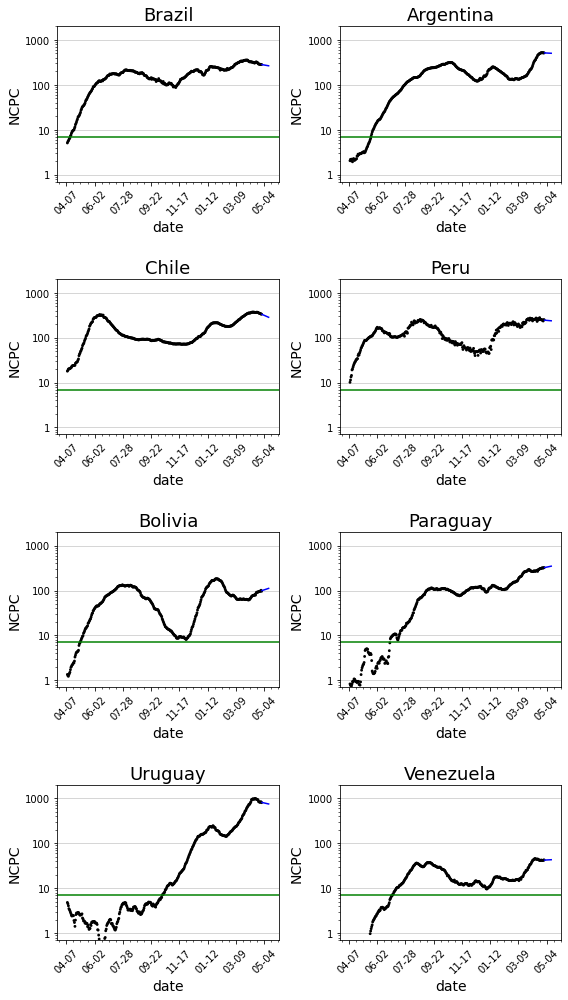

In [18]:
def get_population(iso_code, data):
    """
    Get the population for a particular country, based on total cases and cases per million.
    """
    df = data[data.iso_code == iso_code]  # grab only the rows corresponding to the specific iso code
    pops = df["total_cases"] / df["total_cases_per_million"]
    return int(pops.mean() * 1000000)
    
def get_matrix1(ordered_iso_codes, data, iso_mapping, filename=""):
    """
    ``data`` is your entire dataframe (the whole thing)
    
    ``ordered_iso_codes`` looks like, e.g., ['IRL','GBR', 'PRT'].
        You put the iso codes in the order you want and this function outputs a DataFrame
        which has the full country names in the same order.
        
    ``save_csv`` is a filename if you want to save it, otherwise just don't use it.
    """
    region = data.query(f"iso_code in {ordered_iso_codes}")
    region = region.pivot(columns='iso_code', values='total_cases')
    region = region[ordered_iso_codes]
    region.rename(iso_mapping[region.columns].to_dict(), axis=1, inplace=True)
    region = region[region.index > "2020-03-25"]
    region.columns.name = None
    if filename:
        region.to_csv(filename)
    return region

def get_matrix2(matrix1, iso_list, data):
    populations = np.array([get_population(country, data=data) for country in iso_list])
    return matrix1.diff().rolling(14).mean() / (populations/1000000)

def get_matrix3(matrix2):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return np.log10(matrix2)

def linear_regression(country_col, future_day_count):
    # pred_idx is a list of the next `future_day_count` days, starting tomorrow.
    # Each of the elements are dates, not numbers.
    pred_idx = pd.date_range(start=country_col.index[-1] + pd.Timedelta(days=1), 
                             periods=future_day_count, freq="D")
    
    # days_from_start is a list of numbers, each of which denotes one of the previous 7 days,
    # starting with 0 (0 representing 7 days ago)
    days_from_start = (country_col.index - country_col.index[0]).days
    
    # the integer-day index for tomorrow.
    tomorrow = days_from_start[-1] + 1
    
    # the integer-day indices for the days we want to predict.
    to_pred = np.arange(tomorrow, tomorrow + future_day_count).reshape(-1, 1)
    
    # Get the pure integer indices for the days that we're fitting the linear regression on,
    # in integers, and then format properly
    X = days_from_start.values.reshape(-1, 1)
    
    # get the actual values for the days we're fitting the linear regression on, then format properly
    Y = country_col.values.reshape(-1, 1)
    
    # Fit out linear regression model on the previous 7 days, then predict the next `future_day_count` days
    y_pred = LinearRegression().fit(X, Y).predict(to_pred)
    
    # Give back the dates that we predicted, and the predicted values
    return pred_idx, y_pred.squeeze()

def predict_future(df, future_day_count=14):
    last_7_days = df[-7:]
    df_dict = {}
    for col in last_7_days:
        series = last_7_days[col]
        idx, pred = linear_regression(series, future_day_count=future_day_count)
        df_dict[col] = pred

    return 10**pd.DataFrame(df_dict, index=idx)

def main(isos, rows_cols=(None, None), filename=""):
    
    # grab matrices
    matrix1 = get_matrix1(isos, data=df, iso_mapping=iso_mapping)
    matrix2 = get_matrix2(matrix1, isos, data=df)
    matrix3 = get_matrix3(matrix2)
    final = 10**matrix3
    
    # add regression prediction
    regression_predictions = predict_future(matrix3, future_day_count=14)
    
    # --- Plotting --- #
    
    # By default, create the grid dynamically with 4 columns and changing 
    # number of rows. If you want, you can pass a specific number of rows
    # and columns by passing (rows_cols) to this function.
    n_plots = len(isos)
    if rows_cols == (None, None):
        ncols = 4
        quotient, remainder = divmod(n_plots, ncols)
        nrows = quotient if remainder==0 else quotient+1
    else:
        nrows, ncols = rows_cols
        quotient, remainder = divmod(n_plots, ncols)
        
    # set up figure by making an empty grid of plots, each of which will get 
    # data added to it in the country loop
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4, nrows*3.5))
        
    # get rid of any plots we aren't using
    if remainder != 0:
        diff = len(axs.flat) - len(isos)
        for ax in axs.flat[-diff:]:
            ax.set_axis_off()
    
    # loop through the countries we're plotting, and make a 
    # plot for each country
    for i, iso in enumerate(isos):
        
        # get the name of the country and create a scatterplot
        country_name = iso_mapping[iso]
        ax = axs.flat[i]
        g = sns.scatterplot(data=final, x=final.index, y=country_name, 
                            ax=ax, color="black", edgecolor="none", s=8, )
        
        # add regression line to the current country plot and make blue
        sns.lineplot(data=regression_predictions, x=regression_predictions.index, 
                     y=country_name, ax=g, color="blue")
        
        
        # add title and set y-axis to logarithmic scale
        g.set_title(f"{country_name}", fontsize=18)
        g.set(yscale="log", ylabel="NCPC", ylim=(.7, 2000))
        
        # mess with x-axis ticks
        g.xaxis.set_minor_locator(mdates.WeekdayLocator(interval=2))  # change the interval for the smaller ticks on x-axis to every 2 days
        g.xaxis.set_major_locator(mdates.WeekdayLocator(interval=8))  # change the interval for the larger ticks on x-axis to every 8 days
        g.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))  # show x-ticks in month-day format, don't display years
        g.xaxis.label.set_size(14)  # sets size of x-axis label
        g.tick_params(axis='x', labelrotation=45)  # rotate ticks by 45 degrees
        
        # mess with y-axis ticks
        g.yaxis.set_major_formatter(ScalarFormatter())  # ticks in integers rather than scientific notation
        g.yaxis.label.set_size(14)  # sets size of y-axis label
        
        # add green horizontal line
        g.axhline(y=7, color="green")
        
        # add horizontal grid lines, make the color black, give them transparency of 0.1
        g.yaxis.grid(which='major', color='black', alpha=0.2)
        
    # Increase the vertical (height) distance between plots on the grid
    plt.tight_layout(h_pad=2.5)
    
    # save the figure
    if filename:
        plt.savefig(filename, bbox_inches="tight", dpi=72)
    
# Actually run the program
main(isos, rows_cols=rows_cols, filename=filename)  

# Dad Playground

In [22]:
isos = ['BRA', 'ARG', 'CHL', 'PER', 'BOL', 'PRY', 'URY', 'VEN']
df = get_current_data(level="country")
matrix1 = get_matrix1(isos, df, iso_mapping)


matrix1.head()

,Brazil,Argentina,Chile,Peru,Bolivia,Paraguay,Uruguay,Venezuela
date,,,,,,,,
2020-03-26,2985.0000000000,502.0000000000,1361.0000000000,580.0000000000,43.0000000000,41.0000000000,238.0000000000,107.0000000000
2020-03-27,3417.0000000000,589.0000000000,1665.0000000000,635.0000000000,61.0000000000,52.0000000000,274.0000000000,107.0000000000
2020-03-28,3904.0000000000,690.0000000000,2015.0000000000,671.0000000000,74.0000000000,56.0000000000,303.0000000000,119.0000000000
2020-03-29,4256.0000000000,745.0000000000,2245.0000000000,852.0000000000,81.0000000000,59.0000000000,309.0000000000,119.0000000000
2020-03-30,4579.0000000000,820.0000000000,2555.0000000000,950.0000000000,97.0000000000,64.0000000000,320.0000000000,135.0000000000


## Utility: finding ISO codes

Use the two cells below to find ISOs from country names or vice-versa.
- the `iso_mapping` variable contains the entire list of mappings

In [13]:
# You can get isos from countries with
# isos = list(country_to_iso(["Ireland", "United Kingdom", "Portugal", "Spain", "France", 'Italy', 'Belgium', 'Luxembourg']))
# isos = list(country_to_iso(["Ireland", "United Kingdom", "Portugal", "Spain", "France", "Italy", "Belgium", "Luxembourg"]))
# isos = list(country_to_iso(["Brazil", "Argentina", "Chile", "Peru", "Bolivia", "Venezuala", "Colombia", "Paraguay", "Uraguay"]))

# Or just pass in a single country:
isos_from_countries = list(country_to_iso(["Brazil", "Argentina","Chile", "Peru", "Bolivia", "Paraguay", "Uruguay", "Venezuela", "Colombia"]))
print(isos)

['BRA', 'ARG', 'CHL', 'PER', 'BOL', 'PRY', 'URY', 'VEN']


In [14]:
# You can get countries from isos with
country_names = list(iso_to_country(isos))
print(country_names)

# Or a single iso:
iso_to_country("GBR")

['Brazil', 'Argentina', 'Chile', 'Peru', 'Bolivia', 'Paraguay', 'Uruguay', 'Venezuela']


'United Kingdom'

# Notes from when I made the functions all separately

## Get data for daily regions (cases)

The below code will grab the current data and cache it into a local .csv file.  

If you already have the local csv file and it's up-to-date (meaning, the most recent date in it is greater than or equal to yesterday), just use the local csv file to avoid re-downloading uneccesarily.

If you don't already have the local csv file, download it as well.

**useful things**
- check out the variable `iso_mapping`. It maps iso codes to country names.
- You can use this to look at particular country codes. For example, you could type `iso_mapping[['HUN', 'EST']]` to look at the iso conversions for Hungary and Estonia.

## Matrix 1

The below code creates Matrix 1 for each cell. Feel free to peruse it. You just pass a list of ISO codes into `convert`. More information in the string underneath the `convert` definition (`def`).

**useful things**
- the `iso_to_country` function eats an ISO and outputs a country name. For example, iso_to_country("IRL") returns "Ireland".
- the `country_to_iso` function eats a country and outputs an ISO. For example, country_to_iso("Ireland") returns "IRL".

## Matrix 2

This code calculates matrix 2. There are small disparity between these numbers and the ones in the Excel spreadsheet -- that's because I calculated population manually based on the original countries_data, rather than using the numbers in the sheet. 

If you'd like you can replace `populations = np.array([get_population(country) for country in iso_list])` with `populations = np.array([4.977, 67.886, 10.296, 47.431, 67.081, 60.317, 11.493, 0.626])` for e.g. EU1. 

I personally think this is too much of a hassle.

## Matrix 4

The fun part!

Thoughts:
- Lasso Regression or Elastic Regression is almost always better to use than normal linear regression. I can swap those out very easily if you'd like.